# Secure Data Disclosure: Client side

This notebook showcases how researcher could use the Secure Data Disclosure system. It explains the different functionnalities provided by the `fso-sdd-demo` client library to interact with the secure server.

The secure data are never visible by researchers. They can only access to differentially private responses via queries to the server.

Each user has access to one or multiple projects and for each dataset has a limited budget with $\epsilon$ and $\delta$ values.

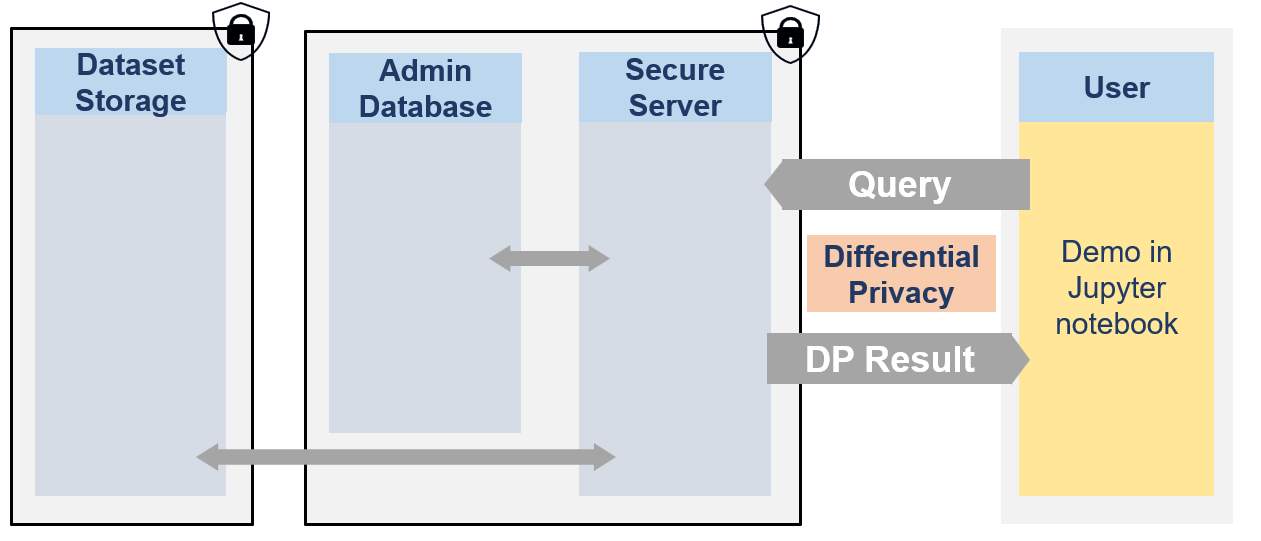

In [1]:
from IPython.display import Image
Image(filename="images/image_demo_client.png", width=800)

🐧🐧🐧
In this notebook the researcher is a penguin researcher named Dr. Antarctica. She aims to do a grounbdbreaking research on various penguins dimensions.

Therefore, the powerful queen Icerbegina 👑 had the data collected. But in order to get the penguins to agree to participate she promised them that no one would be able to look at the data and that no one would be able to guess the bill width of any specific penguin (which is very sensitive information) from the data. Nobody! Not even the researchers. The queen hence stored the data on the Secure Data Disclosure Server and only gave a small budget to Dr. Antarctica.

This is not a problem for Dr. Antarctica as she does not need to see the data to make statistics thanks to the Secure Data Disclosure Client library `fso-sdd-demo`. 
🐧🐧🐧

## Step 1: Install the library
To interact with the secure server on which the data is stored, Dr.Antartica first needs to install the library `fso-sdd-demo` on her local developping environment. 

It can be installed via the pip command:

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
# !pip install lomas_client

In [3]:
from lomas_client import Client
import numpy as np

## Step 2: Initialise the client

Once the library is installed, a Client object must be created. It is responsible for sending sending requests to the server and processing responses in the local environment. It enables a seamless interaction with the server. 

To create the client, Dr. Antartica needs to give it a few parameters:
- a url: the root application endpoint to the remote secure server.
- user_name: her name as registered in the database (Dr. Alice Antartica)
- dataset_name: the name of the dataset that she wants to query (PENGUIN)

She will only be able to query on the real dataset if the queen Icergina has previously made her an account in the database, given her access to the PENGUIN dataset and has given her some epsilon and delta credit (as is done in the Admin Notebook for Users and Datasets management).

In [4]:
APP_URL = "http://lomas_server"
USER_NAME = "Dr. Antartica"
DATASET_NAME = "PENGUIN"
client = Client(url=APP_URL, user_name = USER_NAME, dataset_name = DATASET_NAME)

And that's it for the preparation. She is now ready to use the various functionnalities offered by `fso_sdd_demo`.

## Step 3: Metadata and dummy dataset

### Getting dataset metadata

Dr. Antartica has never seen the data and as a first step to understand what is available to her, she would like to check the metadata of the dataset. Therefore, she just needs to call the `get_dataset_metadata()` function of the client. As this is public information, this does not cost any budget.

This function returns metadata information in a format based on [SmartnoiseSQL dictionary format](https://docs.smartnoise.org/sql/metadata.html#dictionary-format), where among other, there is information about all the available columns, their type, bound values (see Smartnoise page for more details). Any metadata is required for Smartnoise-SQL is also required here and additional information such that the different categories in a string type column column can be added.

In [5]:
penguin_metadata = client.get_dataset_metadata()
penguin_metadata

{'max_ids': 1,
 'row_privacy': True,
 'censor_dims': False,
 'columns': {'species': {'type': 'string',
   'cardinality': 3,
   'categories': ['Adelie', 'Chinstrap', 'Gentoo']},
  'island': {'type': 'string',
   'cardinality': 3,
   'categories': ['Torgersen', 'Biscoe', 'Dream']},
  'bill_length_mm': {'type': 'float', 'lower': 30.0, 'upper': 65.0},
  'bill_depth_mm': {'type': 'float', 'lower': 13.0, 'upper': 23.0},
  'flipper_length_mm': {'type': 'float', 'lower': 150.0, 'upper': 250.0},
  'body_mass_g': {'type': 'float', 'lower': 2000.0, 'upper': 7000.0},
  'sex': {'type': 'string',
   'cardinality': 2,
   'categories': ['MALE', 'FEMALE']}}}

Based on this Dr. Antartica knows that there are 7 columns, 3 of string type (species, island, sex) with their associated categories (i.e. the species column has 3 possibilities: 'Adelie', 'Chinstrap', 'Gentoo') and 4 of float type (bill length, bill depth, flipper length and body mass) with their associated bounds (i.e. the body mass of penguin ranges from 2000 to 7000 gramms). She also knows based on the field `max_ids: 1` that each penguin can only be once in the dataset and on the field `row_privacy: True` that each row represents a single penguin. 

### Get a dummy dataset

Now, that she has seen and understood the metadata, she wants to get an even better understanding of the dataset (but is still not able to see it). A solution to have an idea of what the dataset looks like it to create a dummy dataset. 

Based on the public metadata of the dataset, a random dataframe can be created created. By default, there will be 100 rows and the seed is set to 42 to ensure reproducibility, but these 2 variables can be changed to obtain different dummy datasets.
Getting a dummy dataset does not affect the budget as there is no differential privacy here. It is not a synthetic dataset and all that could be learn here is already present in the public metadata (it is created randomly on the fly based on the metadata).

Dr. Antartica first create a dummy dataset with 200 rows and chooses a seed of 0.

In [6]:
NB_ROWS = 200
SEED = 0

In [7]:
df_dummy = client.get_dummy_dataset(
    nb_rows = NB_ROWS, 
    seed = SEED
)

print(df_dummy.shape)
df_dummy.head()

(200, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Gentoo,Biscoe,49.208473,16.117959,190.125950,2873.291927,FEMALE
1,Gentoo,Torgersen,55.031628,19.963435,242.929142,3639.940005,FEMALE
2,Chinstrap,Torgersen,51.096718,16.777518,159.961493,5401.743330,MALE
3,Adelie,Biscoe,49.070911,14.796037,244.530153,2316.038092,MALE
4,Chinstrap,Biscoe,44.827918,13.246787,236.948853,5036.246870,FEMALE


## Step 4: Train Logistic Regression model with DiffPrivLib

We want to train an ML model to guess the species of penguins based on their bill length and depth, flipper length and body mass.

Therefore, we use a DiffPrivLib pipeline which:
- standard scales the dimensions between the metadata bounds
- and then performs a logistic regression
to predict the species of penguins.

In [8]:
from sklearn.pipeline import Pipeline
from diffprivlib import models
import pandas as pd

### Classification: Logistic Regression

In [9]:
import warnings
from diffprivlib import models
from diffprivlib.utils import (
    DiffprivlibCompatibilityWarning,
    PrivacyLeakWarning,
)
warnings.simplefilter("error", DiffprivlibCompatibilityWarning)

#### DiffprivlibCompatibilityWarning will not work

In [10]:
# DiffprivlibCompatibilityWarning Error expected
dpl_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5)),
    ('classifier', models.LogisticRegression(epsilon = 1.0, svd_solver='full'))
])

DiffprivlibCompatibilityWarning: Parameter 'svd_solver' is not functional in diffprivlib.  Remove this parameter to suppress this warning.

To resolve the DiffprivlibCompatibilityWarning issue, the svd_solver should not be set as it i incompatible with diffprivlib.

#### PrivacyLeakWarning will not be processed within server

In [13]:
dpl_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=BOUNDS)),
    ('classifier', models.LogisticRegression(epsilon = 1.0))
])

In [14]:
# Expect PrivacyLeakWarning Error
dummy_response = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
    test_train_split_seed = 1,
    dummy = True
)

Error while processing DiffPrivLib request in server                 status code: 422 message: {"ExternalLibraryException":"PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.. Lomas server cannot fit pipeline on data, PrivacyLeakWarning is a blocker.","library":"diffprivlib"}


Diffprivlib requests that have **PrivacyLeakWarning** will not be processed in the server. 
In lomas, **the standard scaler must always be used as a first step** and filled based on the metadata values.

In [15]:
bl_l = penguin_metadata['columns']['bill_length_mm']['lower']
bl_u = penguin_metadata['columns']['bill_length_mm']['upper']
bd_l = penguin_metadata['columns']['bill_depth_mm']['lower']
bd_u = penguin_metadata['columns']['bill_depth_mm']['upper']
fl_l = penguin_metadata['columns']['flipper_length_mm']['lower']
fl_u = penguin_metadata['columns']['flipper_length_mm']['upper']
bm_l = penguin_metadata['columns']['body_mass_g']['lower']
bm_u = penguin_metadata['columns']['body_mass_g']['upper']

BOUNDS = ([bl_l, bd_l, fl_l, bm_l], [bl_u, bd_u, fl_u, bm_u])
BOUNDS

([30.0, 13.0, 150.0, 2000.0], [65.0, 23.0, 250.0, 7000.0])

For the same reason, the data_norm should be computed based on metadata and given as argument.

In [18]:
# The max l2 norm of any row of the data. This defines the spread of data that will be protected by differential privacy.
data_norm = np.sqrt(np.linalg.norm([bl_u, bd_u, fl_u, bm_u]))
data_norm

83.69469642643347

In [19]:
dpl_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=([bl_l, bd_l, fl_l, bm_l], [bl_u, bd_u, fl_u, bm_u]))),
    ('classifier', models.LogisticRegression(epsilon = 1.0, data_norm = data_norm))
])

In [20]:
dummy_response = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
    test_train_split_seed = 1,
    dummy = True
)

In [21]:
print(f"The accuracy score of the dummy_response is {dummy_response['query_response']['score']}.")

The accuracy score of the dummy_response is 0.3.


In [22]:
res = client.estimate_diffprivlib_cost(
    dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
    test_train_split_seed = 1
)
res

{'epsilon_cost': 1.5, 'delta_cost': 0.0}

In [23]:
dummy_response['query_response']["model"]

Pipeline(steps=[('scaler',
                 StandardScaler(accountant=BudgetAccountant(spent_budget=[(0.5, 0)]),
                                bounds=(array([  30.,   13.,  150., 2000.]),
                                        array([  65.,   23.,  250., 7000.])),
                                epsilon=0.5)),
                ('classifier',
                 LogisticRegression(accountant=BudgetAccountant(spent_budget=[(1.0, 0)]),
                                    data_norm=83.69469642643347))])

Now we train the same pipeline on the real dataset.

In [24]:
res = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
    test_train_split_seed = 1
)
res

{'requested_by': 'Dr. Antartica',
 'query_response': {'score': 0.13432835820895522,
  'model': Pipeline(steps=[('scaler',
                   StandardScaler(accountant=BudgetAccountant(spent_budget=[(0.5, 0)]),
                                  bounds=(array([  30.,   13.,  150., 2000.]),
                                          array([  65.,   23.,  250., 7000.])),
                                  epsilon=0.5)),
                  ('classifier',
                   LogisticRegression(accountant=BudgetAccountant(spent_budget=[(1.0, 0)]),
                                      data_norm=83.69469642643347))])},
 'spent_epsilon': 1.5,
 'spent_delta': 0.0}

In [25]:
print(f"The accuracy score of the model trained on real data is {res['query_response']['score']}.")

The accuracy score of the model trained on real data is 0.13432835820895522.


The model is of course the same but with different trained parameters.

In [26]:
model = res['query_response']['model']

We predict what would be the specy of the smallest possible penguin in all dimension versus to biggest possible penguin in all dimensions.

In [27]:
x_to_predict = pd.DataFrame({
    'bill_length_mm': [bl_l, bl_u], 
    'bill_depth_mm': [bd_l, bd_u] , 
    'flipper_length_mm': [fl_l, fl_u], 
    'body_mass_g': [bm_l, bm_u]
})

In [28]:
predictions = model.predict(x_to_predict)
predictions

array(['Chinstrap', 'Gentoo'], dtype=object)

Indeed, Chinstrap penguins are typically smaller than Gentoo penguins.

## Step 5: Train other models with DiffPrivLib

### Classification: Gaussian Naive Bayes

In [25]:
dpl_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=BOUNDS)),
    ('gaussian', models.GaussianNB(epsilon = 1.0, bounds=BOUNDS, priors = (0.3, 0.3, 0.4))),
])

In [26]:
dummy_response = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
    dummy = True
)

In [27]:
cost_res = client.estimate_diffprivlib_cost(
    dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
    test_train_split_seed = 1
)
cost_res

{'epsilon_cost': 1.5, 'delta_cost': 0.0}

In [28]:
response = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
)

In [29]:
model = res['query_response']['model']
predictions = model.predict(x_to_predict)
predictions

array(['Adelie', 'Chinstrap'], dtype=object)

### Random Forest

In [30]:
dpl_pipeline = Pipeline([
    ('rf', models.RandomForestClassifier(n_estimators=10, epsilon = 2.0, bounds=BOUNDS, classes=['Adelie', 'Chinstrap', 'Gentoo'])),
])

In [31]:
dummy_response = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
    dummy = True
)

In [32]:
cost_res = client.estimate_diffprivlib_cost(
    dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
    test_train_split_seed = 1
)
cost_res

{'epsilon_cost': 2.0, 'delta_cost': 0.0}

In [33]:
response = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
)

In [34]:
model = res['query_response']['model']
model

Pipeline(steps=[('scaler',
                 StandardScaler(accountant=BudgetAccountant(spent_budget=[(0.5, 0)]),
                                bounds=(array([  30.,   13.,  150., 2000.]),
                                        array([  65.,   23.,  250., 7000.])),
                                epsilon=0.5)),
                ('classifier',
                 LogisticRegression(accountant=BudgetAccountant(spent_budget=[(1.0, 0)]),
                                    data_norm=83.69469642643347))])

In [35]:
predictions = model.predict(x_to_predict)
predictions

array(['Adelie', 'Chinstrap'], dtype=object)

### Decision Tree Classifier

In [36]:
dpl_pipeline = Pipeline([
    ('dtc', models.DecisionTreeClassifier(epsilon = 2.0, bounds=BOUNDS, classes=['Adelie', 'Chinstrap', 'Gentoo'])),
])

In [37]:
dummy_response = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
    test_train_split_seed = 1,
    dummy = True,
    nb_rows = 100,
    seed = 42
)

In [38]:
response = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = ['species'],
    test_size = 0.2,
)

In [39]:
model = res['query_response']['model']
predictions = model.predict(x_to_predict)
predictions

array(['Adelie', 'Chinstrap'], dtype=object)

### Regression: Linear Regression

In [40]:
dpl_pipeline = Pipeline([
    ('lr', models.LinearRegression(epsilon = 2.0, bounds_X=(bl_l, bl_u), bounds_y=(bd_l, bd_u))),
])

In [41]:
dummy_response = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns =  ['bill_length_mm'],
    target_columns = ['bill_depth_mm'],
    dummy = True
)
model = dummy_response['query_response']['model']
model

Pipeline(steps=[('lr',
                 LinearRegression(accountant=BudgetAccountant(spent_budget=[(2.0, 0)]),
                                  bounds_X=(array([30.]), array([65.])),
                                  bounds_y=(array([13.]), array([23.])),
                                  epsilon=2.0))])

In [42]:
# Dummy model predictions
x_to_predict = pd.DataFrame({'bill_length_mm': [bl_l, bl_u]})
predictions = model.predict(x_to_predict)
predictions

array([[18.84279457],
       [18.24687217]])

### Clustering: K-Means

In [54]:
dpl_pipeline = Pipeline([
    ('kmeans', models.KMeans(n_clusters = 8, epsilon = 2.0, bounds=BOUNDS)),
])

In [55]:
dummy_response = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    dummy = True
)
model = dummy_response['query_response']['model']
model

Pipeline(steps=[('kmeans',
                 KMeans(accountant=BudgetAccountant(spent_budget=[(2.0, 0)]),
                        bounds=(array([  30.,   13.,  150., 2000.]),
                                array([  65.,   23.,  250., 7000.])),
                        epsilon=2.0))])

In [56]:
# Dummy model predictions
x_to_predict = pd.DataFrame({
    'bill_length_mm': [bl_l, bl_u], 
    'bill_depth_mm': [bd_l, bd_u] , 
    'flipper_length_mm': [fl_l, fl_u], 
    'body_mass_g': [bm_l, bm_u]
})
predictions = model.predict(x_to_predict)
predictions

array([1, 2], dtype=int32)

### Dimensionality Reduction: PCA

In [57]:
dpl_pipeline = Pipeline([
    ('pca', models.PCA(n_components=None, epsilon = 2.0, bounds=BOUNDS, data_norm=100, centered=False)),
])

In [58]:
dummy_response = client.diffprivlib_query(
    pipeline = dpl_pipeline,
    feature_columns =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    target_columns = None, # TODO enable empty list
    dummy = True
)

In [59]:
dummy_response

{'query_response': {'score': -3532.5573958633877,
  'model': Pipeline(steps=[('pca',
                   PCA(accountant=BudgetAccountant(spent_budget=[(2.0, 0)]),
                       bounds=(array([  30.,   13.,  150., 2000.]),
                               array([  65.,   23.,  250., 7000.])),
                       data_norm=100, epsilon=2.0))])}}

## Step 6: See archives of queries

She now wants to verify all the queries that she did on the real data. It is possible because an archive of all queries is kept in a secure database. With a function call she can see her queries, budget and associated responses.

In [93]:
previous_queries = client.get_previous_queries()

Let's check the first query, which was with smartnoise-sql:

In [94]:
query_1 = previous_queries[0]
query_1

{'user_name': 'Dr. Antartica',
 'dataset_name': 'PENGUIN',
 'dp_librairy': 'diffprivlib',
 'client_input': {'dataset_name': 'PENGUIN',
  'diffprivlib_json': '{"module": "diffprivlib", "version": "0.6.4", "pipeline": [{"type": "_dpl_type:StandardScaler", "name": "scaler", "params": {"with_mean": true, "with_std": true, "copy": true, "epsilon": 0.5, "bounds": {"_tuple": true, "_items": [[30.0, 13.0, 150.0, 2000.0], [65.0, 23.0, 250.0, 7000.0]]}, "random_state": null, "accountant": "_dpl_instance:BudgetAccountant"}}, {"type": "_dpl_type:LogisticRegression", "name": "classifier", "params": {"tol": 0.0001, "C": 1.0, "fit_intercept": true, "random_state": null, "max_iter": 100, "verbose": 0, "warm_start": false, "n_jobs": null, "epsilon": 1.0, "data_norm": 83.69469642643347, "accountant": "_dpl_instance:BudgetAccountant"}}]}',
  'feature_columns': ['bill_length_mm',
   'bill_depth_mm',
   'flipper_length_mm',
   'body_mass_g'],
  'target_columns': ['species'],
  'test_size': 0.2,
  'test_tra

The second with opendp:

In [95]:
query_2 = previous_queries[1]
query_1

{'user_name': 'Dr. Antartica',
 'dataset_name': 'PENGUIN',
 'dp_librairy': 'diffprivlib',
 'client_input': {'dataset_name': 'PENGUIN',
  'diffprivlib_json': '{"module": "diffprivlib", "version": "0.6.4", "pipeline": [{"type": "_dpl_type:StandardScaler", "name": "scaler", "params": {"with_mean": true, "with_std": true, "copy": true, "epsilon": 0.5, "bounds": {"_tuple": true, "_items": [[30.0, 13.0, 150.0, 2000.0], [65.0, 23.0, 250.0, 7000.0]]}, "random_state": null, "accountant": "_dpl_instance:BudgetAccountant"}}, {"type": "_dpl_type:LogisticRegression", "name": "classifier", "params": {"tol": 0.0001, "C": 1.0, "fit_intercept": true, "random_state": null, "max_iter": 100, "verbose": 0, "warm_start": false, "n_jobs": null, "epsilon": 1.0, "data_norm": 83.69469642643347, "accountant": "_dpl_instance:BudgetAccountant"}}]}',
  'feature_columns': ['bill_length_mm',
   'bill_depth_mm',
   'flipper_length_mm',
   'body_mass_g'],
  'target_columns': ['species'],
  'test_size': 0.2,
  'test_tra

And the last one with DiffPrivLib:

In [96]:
query_3 = previous_queries[-1]
query_3

{'user_name': 'Dr. Antartica',
 'dataset_name': 'PENGUIN',
 'dp_librairy': 'diffprivlib',
 'client_input': {'dataset_name': 'PENGUIN',
  'diffprivlib_json': '{"module": "diffprivlib", "version": "0.6.4", "pipeline": [{"type": "_dpl_type:RandomForestClassifier", "name": "rf", "params": {"n_estimators": 10, "n_jobs": 1, "random_state": null, "verbose": 0, "warm_start": false, "max_depth": 5, "epsilon": 2.0, "bounds": {"_tuple": true, "_items": [[30.0, 13.0, 150.0, 2000.0], [65.0, 23.0, 250.0, 7000.0]]}, "classes": ["Adelie", "Chinstrap", "Gentoo"], "shuffle": false, "accountant": "_dpl_instance:BudgetAccountant"}}]}',
  'feature_columns': ['bill_length_mm',
   'bill_depth_mm',
   'flipper_length_mm',
   'body_mass_g'],
  'target_columns': ['species'],
  'test_size': 0.2,
  'test_train_split_seed': 1,
  'imputer_strategy': 'drop'},
 'response': {'requested_by': 'Dr. Antartica',
  'query_response': {'score': 0.6268656716417911,
   'model': Pipeline(steps=[('rf',
                    RandomF